# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

#### Observations

The number of campaigns is not mentioned anywhere in the paper. However, exploratory data analysis shows that around 41,000 calls were made in a five-year period.

In [100]:
# import required libraries

import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

# models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import *

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd

In [3]:
# set up environment and connect to Google Drive
import os

from google.colab import drive

drive_root = '/content/drive'
if not os.path.exists(drive_root):
  drive.mount(drive_root)

colab_home = f'{drive_root}/MyDrive/Colab'
ws = f'{colab_home}/workspace_ucb_ml'

os.chdir(ws)

Mounted at /content/drive


In [4]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep=';')

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
df.shape[0]

41188

#### Observations

* `df.info()` indicates there is no missing data (see below section)
* The data contains 10 categorical features that need to be encoded:
  * `job`
  * `marital`
  * `education`
  * `default`
  * `housing`
  * `loan`
  * `contact`
  * `month`
  * `day_of_week`
  * `poutcome`
* The target variable `y` is imbalanced but not extremely so

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

#### Exploratory data analysis

In [9]:
# get summary of non-nominal data
df.select_dtypes('number').drop('campaign', axis=1).describe()

,age,duration,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


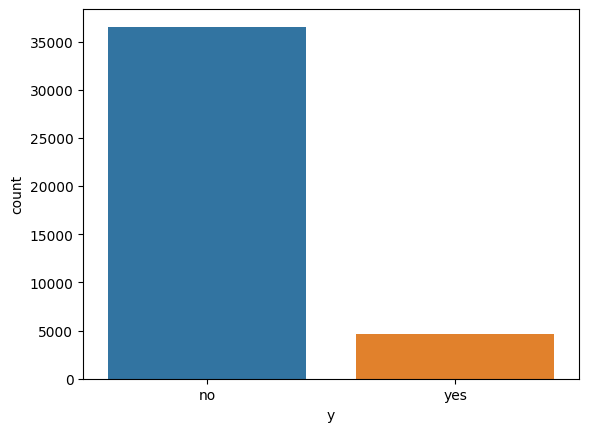

In [10]:
# visualize target variable
sns.countplot(data=df, x='y', hue='y')
plt.show()

In [11]:
df['y'].value_counts(normalize=True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

#### Business objective

A financial institution based in Portugal has collected data for over 41,000 telemarketing calls made over a five-year period. It wishes to use this data to predict whether or not a sales lead may become a client in the future. Given the opportunity cost of missing out on a potential customer, the ultimate goal is to minimize the number of false negatives.

Because each lead either is or is not a customer, this is a binary classification problem. We implement several different models (such as *k*-nearest neighbors, logistic regression and support vector machines) to find the one with the highest predictive performance, and we also investigate methods to further optimize the models.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [12]:
# create subset of data
ss = df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'y']]

In [13]:
# apply one-hot encoder
cols = ['job', 'marital', 'education', 'default', 'housing' ,'loan', 'contact']

transformer = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), cols)
)

"Unknown" values are equivalent to missing data. We create a copy of the data but replace "unknown" with the mode to see if this improves results. This also reduces the number of dummy variables as well as the training time.

In [14]:
ss_mode = ss.copy()

In [15]:
for col in cols:
  ss_mode[col].replace('unknown', ss_mode[col][df[col] != 'unknown'].mode()[0], inplace=True)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [16]:
X = ss.drop('y', axis=1)
y = ss['y']

In [17]:
X_mode = ss_mode.drop('y', axis=1)

In [18]:
test_ratio = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=1)

In [19]:
X_mode_train, X_mode_test, _, _ = train_test_split(X_mode, y, test_size=test_ratio, random_state=1)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [27]:
# use a dummy classifier to get a baseline score
dummy = DummyClassifier()

In [28]:
start = time.time()
dummy.fit(X_train, y_train)
end = time.time()
dummy_time = end - start
dummy

DummyClassifier()

In [29]:
dummy_time *= 1000
print(f'DummyClassifier() run time: {dummy_time} ms')

DummyClassifier() run time: 21.254777908325195 ms


In [30]:
dummy_train_acc = dummy.score(X_train, y_train)
dummy_test_acc = dummy.score(X_test, y_test)

print('Baseline training accuracy:', dummy_train_acc)
print('Baseline test accuracy:', dummy_test_acc)

Baseline training accuracy: 0.88807186708751
Baseline test accuracy: 0.8856518572469045


In [31]:
y_pred_dummy_train = dummy.predict(X_train)
y_pred_dummy_test = dummy.predict(X_test)

dummy_train_f1 = f1_score(y_train, y_pred_dummy_train, pos_label='yes')
dummy_test_f1 = f1_score(y_test, y_pred_dummy_test, pos_label='yes')

print('Baseline training F_1 score:', dummy_train_f1)
print('Baseline test F_1 score:', dummy_test_f1)

Baseline training F_1 score: 0.0
Baseline test F_1 score: 0.0


We create a confusion matrix to determine why the F<sub>1</sub> score is 0 for both the training and test sets.

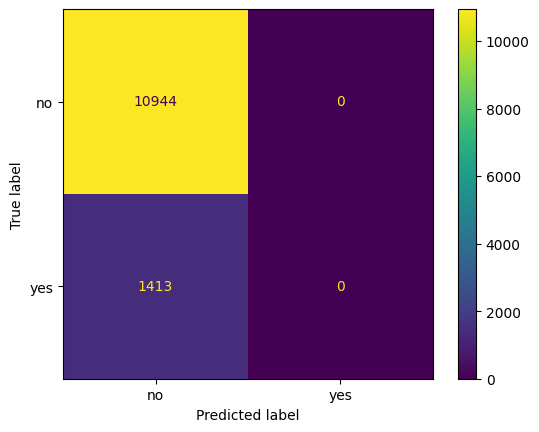

In [35]:
ConfusionMatrixDisplay.from_estimator(dummy, X_test, y_test)
plt.show()

#### Observations

* The baseline classifier has an accuracy of 0.888 for the training set and 0.886 for the test set
* However, the F<sub>1</sub> score is 0 for both sets because the classifier predicts "no" for all data points

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [32]:
lr_pipe = Pipeline([
    ('transform', transformer),
    ('model', LogisticRegression(max_iter=3000))
])

In [38]:
start = time.time()
lr_pipe.fit(X_train, y_train)
end = time.time()
lr_time = end - start
lr_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'contact'])])),
                ('model', LogisticRegression(max_iter=3000))])

In [39]:
lr_time *= 1000
print(f'LogisticRegression() run time: {lr_time} ms')

LogisticRegression() run time: 1224.9031066894531 ms


### Problem 9: Score the Model

What is the accuracy of your model?

In [46]:
y_pred_lr_train = lr_pipe.predict(X_train)
y_pred_lr_test = lr_pipe.predict(X_test)

In [47]:
lr_train_acc = accuracy_score(y_train, y_pred_lr_train)
lr_test_acc = accuracy_score(y_test, y_pred_lr_test)

print("Training accuracy for logistic regression:", lr_train_acc)
print("Test accuracy for logistic regression:", lr_test_acc)

lr_train_f1 = f1_score(y_train, y_pred_lr_train, pos_label='yes')
lr_test_f1 = f1_score(y_test, y_pred_lr_test, pos_label='yes')

print("Training F_1 score for logistic regression:", lr_train_f1)
print("Test F_1 score for logistic regression:", lr_test_f1)

Training accuracy for logistic regression: 0.88807186708751
Test accuracy for logistic regression: 0.8856518572469045
Training F_1 score for logistic regression: 0.0
Test F_1 score for logistic regression: 0.0


Like with the dummy classifier, the F<sub>1</sub> score is 0 because the model predicts "no" for all data points. We create a new logistic regression classifier but use `class_weight='balanced'` to account for the class imbalance.

In [48]:
# repeat the above but account for imbalanced data
lr_pipe_bal = Pipeline([
    ('transform', transformer),
    ('model', LogisticRegression(max_iter=3000, class_weight='balanced'))
])

In [49]:
start = time.time()
lr_pipe_bal.fit(X_train, y_train)
end = time.time()
lr_bal_time = end - start
lr_pipe_bal

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'contact'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=3000))])

In [50]:
lr_bal_time *= 1000
print(f'LogisticRegression() run time with balanced classes: {lr_bal_time} ms')

LogisticRegression() run time with balanced classes: 721.3687896728516 ms


In [41]:
y_pred_lr_bal_train = lr_pipe_bal.predict(X_train)
y_pred_lr_bal_test = lr_pipe_bal.predict(X_test)

In [42]:
lr_bal_train_acc = accuracy_score(y_train, y_pred_lr_bal_train)
lr_bal_test_acc = accuracy_score(y_test, y_pred_lr_bal_test)

print("Training accuracy for logistic regression adjusted for class imbalance:", lr_bal_train_acc)
print("Test accuracy for logistic regression adjusted for class imbalance:", lr_bal_test_acc)

lr_bal_train_f1 = f1_score(y_train, y_pred_lr_bal_train, pos_label='yes')
lr_bal_test_f1 = f1_score(y_test, y_pred_lr_bal_test, pos_label='yes')

print("Training F_1 score for logistic regression adjusted for class imbalance:", lr_bal_train_f1)
print("Test F_1 score for logistic regression adjusted for class imbalance:", lr_bal_test_f1)

Training accuracy for logistic regression adjusted for class imbalance: 0.5807637612292325
Test accuracy for logistic regression adjusted for class imbalance: 0.5909201262442341
Training F_1 score for logistic regression adjusted for class imbalance: 0.27679052234787294
Test F_1 score for logistic regression adjusted for class imbalance: 0.2865208186309104


#### Observations

* The default logistic regression classifier had the same accuracy scores (0.888 for the training set and 0.886 for the test set) as the dummy classifier. This is again the result of predicting "no" for all data points
* Using the `class_weight='balanced'` parameter, the model now correctly classifies some "yes" results, but at the cost of accuracy

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### *k*-nearest neighbors

In [55]:
knn_pipe = Pipeline([
    ('transform', transformer),
    ('model', KNeighborsClassifier())
])

In [56]:
start = time.time()
knn_pipe.fit(X_train, y_train)
end = time.time()
knn_time = end - start
knn_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'contact'])])),
                ('model', KNeighborsClassifier())])

In [57]:
knn_time *= 1000
print(f'KNeighborsClassifier() run time: {knn_time} ms')

KNeighborsClassifier() run time: 116.95981025695801 ms


In [58]:
y_pred_knn_train = knn_pipe.predict(X_train)
y_pred_knn_test = knn_pipe.predict(X_test)

In [59]:
knn_train_acc = accuracy_score(y_train, y_pred_knn_train)
knn_test_acc = accuracy_score(y_test, y_pred_knn_test)

print("Training accuracy for KNN:", knn_train_acc)
print("Test accuracy for KNN:", knn_test_acc)

knn_train_f1 = f1_score(y_train, y_pred_knn_train, pos_label='yes')
knn_test_f1 = f1_score(y_test, y_pred_knn_test, pos_label='yes')

print("Training F_1 score for KNN:", knn_train_f1)
print("Test F_1 score for KNN:", knn_test_f1)

Training accuracy for KNN: 0.8862682529222018
Test accuracy for KNN: 0.8792587197539856
Training F_1 score for KNN: 0.14049803407601574
Test F_1 score for KNN: 0.1097852028639618


#### Decision tree

In [61]:
dt_pipe = Pipeline([
    ('transform', transformer),
    ('model', DecisionTreeClassifier(random_state=1))
])

In [90]:
start = time.time()
dt_pipe.fit(X_train, y_train)
end = time.time()
dt_time = end - start
dt_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'contact'])])),
                ('model', DecisionTreeClassifier(random_state=1))])

In [91]:
dt_time *= 1000
print(f'DecisionTreeClassifier() run time: {dt_time} ms')

DecisionTreeClassifier() run time: 389.7438049316406 ms


In [92]:
y_pred_dt_train = dt_pipe.predict(X_train)
y_pred_dt_test = dt_pipe.predict(X_test)

In [93]:
dt_train_acc = accuracy_score(y_train, y_pred_dt_train)
dt_test_acc = accuracy_score(y_test, y_pred_dt_test)

print("Training accuracy for decision tree:", dt_train_acc)
print("Test accuracy for decision tree:", dt_test_acc)

dt_train_f1 = f1_score(y_train, y_pred_dt_train, pos_label='yes')
dt_test_f1 = f1_score(y_test, y_pred_dt_test, pos_label='yes')

print("Training F_1 score for decision tree:", dt_train_f1)
print("Test F_1 score for decision tree:", dt_test_f1)

Training accuracy for decision tree: 0.8932399153688738
Test accuracy for decision tree: 0.8804726066197297
Training F_1 score for decision tree: 0.13974287311347122
Test F_1 score for decision tree: 0.06813880126182965


#### Support vector machines

In [67]:
svc_pipe = Pipeline([
    ('transform', transformer),
    ('model', SVC())
])

In [68]:
start = time.time()
svc_pipe.fit(X_train, y_train)
end = time.time()
svc_time = end - start
svc_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'contact'])])),
                ('model', SVC())])

In [69]:
svc_time *= 1000
print(f'SVC() run time: {svc_time} ms')

SVC() run time: 28225.508451461792 ms


In [72]:
y_pred_svc_train = svc_pipe.predict(X_train)
y_pred_svc_test = svc_pipe.predict(X_test)

In [73]:
svc_train_acc = accuracy_score(y_train, y_pred_svc_train)
svc_test_acc = accuracy_score(y_test, y_pred_svc_test)

print("Training accuracy for SVC:", svc_train_acc)
print("Test accuracy for SVC:", svc_test_acc)

svc_train_f1 = f1_score(y_train, y_pred_svc_train, pos_label='yes')
svc_test_f1 = f1_score(y_test, y_pred_svc_test, pos_label='yes')

print("Training F_1 score for SVC:", svc_train_f1)
print("Test F_1 score for SVC:", svc_test_f1)

Training accuracy for SVC: 0.88807186708751
Test accuracy for SVC: 0.8856518572469045
Training F_1 score for SVC: 0.0
Test F_1 score for SVC: 0.0


`SVC` predicts "no" for all data points using default settings. We set `class_weight='balanced'` and try again

In [76]:
svc_bal_pipe = Pipeline([
    ('transform', transformer),
    ('model', SVC(class_weight='balanced'))
])

In [77]:
start = time.time()
svc_bal_pipe.fit(X_train, y_train)
end = time.time()
svc_bal_time = end - start
svc_bal_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'contact'])])),
                ('model', SVC(class_weight='balanced'))])

In [78]:
svc_bal_time *= 1000
print(f'SVC() run time with balanced classes: {svc_bal_time} ms')

SVC() run time with balanced classes: 80073.92954826355 ms


In [79]:
y_pred_svc_bal_train = svc_bal_pipe.predict(X_train)
y_pred_svc_bal_test = svc_bal_pipe.predict(X_test)

In [80]:
svc_bal_train_acc = accuracy_score(y_train, y_pred_svc_bal_train)
svc_bal_test_acc = accuracy_score(y_test, y_pred_svc_bal_test)

print("Training accuracy for SVC adjusted for class imbalance:", svc_bal_train_acc)
print("Test accuracy for SVC adjusted for class imbalance:", svc_bal_test_acc)

svc_bal_train_f1 = f1_score(y_train, y_pred_svc_bal_train, pos_label='yes')
svc_bal_test_f1 = f1_score(y_test, y_pred_svc_bal_test, pos_label='yes')

print("Training F_1 score for SVC adjusted for class imbalance:", svc_bal_train_f1)
print("Test F_1 score for SVC adjusted for class imbalance:", svc_bal_test_f1)

Training accuracy for SVC adjusted for class imbalance: 0.6297388227949082
Test accuracy for SVC adjusted for class imbalance: 0.6277413611718055
Training F_1 score for SVC adjusted for class imbalance: 0.29958664129650286
Test F_1 score for SVC adjusted for class imbalance: 0.2907801418439716


In [81]:
model_results = {
    'model': ['Baseline', 'Logistic regression', 'Logistic regression (balanced)', 'KNN', 'Decision tree', 'SVC', 'SVC (balanced)'],
    'train accuracy': [dummy_train_acc, lr_train_acc, lr_bal_train_acc, knn_train_acc, dt_train_acc, svc_train_acc, svc_bal_train_acc],
    'test accuracy': [dummy_test_acc, lr_test_acc, lr_bal_test_acc,  knn_test_acc, dt_test_acc, svc_test_acc, svc_bal_test_acc],
    'train f1': [dummy_train_f1, lr_train_f1, lr_bal_train_f1, knn_train_f1, dt_train_f1, svc_train_f1, svc_bal_train_f1],
    'test f1': [dummy_test_f1, lr_test_f1, lr_bal_test_f1, knn_test_f1, dt_test_f1, svc_test_f1, svc_bal_test_f1],
    'fit time': [dummy_time, lr_time, lr_bal_time, knn_time, dt_time, svc_time, svc_bal_time]
}

results_df = pd.DataFrame(model_results)
results_df.set_index('model', inplace=True)

results_df

,train accuracy,test accuracy,train f1,test f1,fit time
model,,,,,
Baseline,0.888072,0.885652,0.000000,0.000000,21.254778
Logistic regression,0.888072,0.885652,0.000000,0.000000,1224.903107
Logistic regression (balanced),0.580764,0.590920,0.276791,0.286521,721.368790
KNN,0.886268,0.879259,0.140498,0.109785,116.959810
Decision tree,0.893240,0.880473,0.139743,0.068139,689.657450
SVC,0.888072,0.885652,0.000000,0.000000,28225.508451
SVC (balanced),0.629739,0.627741,0.299587,0.290780,80073.929548


#### Observations

* The default `SVC` classifier also predicts "no" for all data points
* However, `SVC` with `class_weight='balanced'` gives much better results while taking longer to run
* Due to the potential opportunity cost of misclassifying potential customers, the ultimate goal should be to minimize false negatives. Because the target variable `y` is unbalanced, the F<sub>1</sub> score is used as the performance metric

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

We run `SVC` on the "mode" data set where unknown values are replaced with the mode.

In [82]:
svc_bal_mode_pipe = Pipeline([
    ('transform', transformer),
    ('model', SVC(class_weight='balanced'))
])

In [83]:
%%time
svc_bal_mode_pipe.fit(X_mode_train, y_train)

CPU times: user 52.7 s, sys: 137 ms, total: 52.9 s
Wall time: 59.7 s


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'contact'])])),
                ('model', SVC(class_weight='balanced'))])

In [84]:
y_pred_svc_mode_train = svc_bal_mode_pipe.predict(X_mode_train)
y_pred_svc_mode_test = svc_bal_mode_pipe.predict(X_mode_test)

In [86]:
svc_mode_train_acc = accuracy_score(y_train, y_pred_svc_mode_train)
svc_mode_test_acc = accuracy_score(y_test, y_pred_svc_mode_test)

print("Training accuracy for SVC() with known values replaced with mode:", svc_mode_train_acc)
print("Test accuracy for SVC() with known values replaced with mode:", svc_mode_test_acc)

svc_mode_train_f1 = f1_score(y_train, y_pred_svc_mode_train, pos_label='yes')
svc_mode_test_f1 = f1_score(y_test, y_pred_svc_mode_test, pos_label='yes')

print("Training F_1 score for SVC() with known values replaced with mode:", svc_mode_train_f1)
print("Test F_1 score for SVC() with known values replaced with mode:", svc_mode_test_f1)

Training accuracy for SVC() with known values replaced with mode: 0.6029967743054351
Test accuracy for SVC() with known values replaced with mode: 0.5973941895282027
Training F_1 score for SVC() with known values replaced with mode: 0.284625
Test F_1 score for SVC() with known values replaced with mode: 0.2765740875381707


Visualize feature importance for decision tree.

In [87]:
def feature_importance(model, features=cols):
  importances = model.feature_importances_

  importance_df = pd.DataFrame(importances, index=features, columns=['Importance']).sort_values(by='Importance', ascending=False)
  plt.figure(figsize=(8, 7))
  sns.barplot(x=importance_df.Importance, y=importance_df.index)
  plt.show()

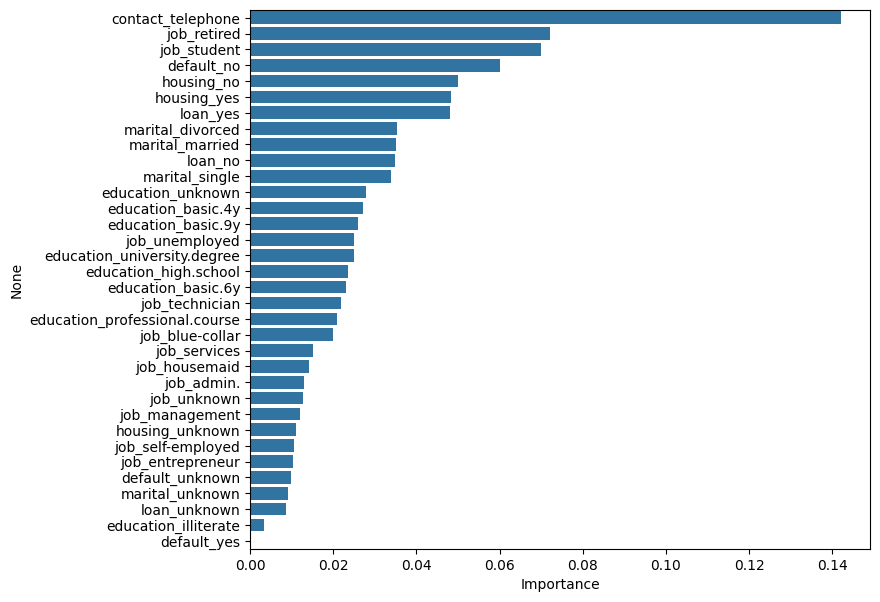

In [102]:
dt = dt_pipe.named_steps['model']
encoder_features = dt_pipe.named_steps['transform'].get_feature_names_out()

features = []

for f in encoder_features:
    features.append(f.split("__")[1])

feature_importance(model=dt, features=features)

In [103]:
max_depth = dt.get_depth()
max_depth

25

In [116]:
# hyperparameters to tune for decision tree
params = {
    'model__max_depth': range(1, max_depth + 1, 3),
    'model__min_samples_split': [2, 5, 10],
    'model__criterion': ['gini', 'entropy']
}

In [121]:
f1_scorer = make_scorer(f1_score, pos_label='yes')
dt_grid = GridSearchCV(dt_pipe, param_grid=params, cv=5, scoring=f1_scorer)
dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=1))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': range(1, 26, 3),
                         'model__min_samples_split': [2, 5, 10]},
             scoring=make_scorer(f1_score, pos_label=yes))

In [122]:
dt_grid.best_estimator_

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan',
                                                   'contact'])])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=25,
                                        random_state=1))])

In [123]:
y_pred_dt_optimized_train = dt_grid.predict(X_train)
y_pred_dt_optimized_test = dt_grid.predict(X_test)

In [124]:
dt_optimized_mode_train_acc = accuracy_score(y_train, y_pred_dt_optimized_train)
dt_optimized_mode_test_acc = accuracy_score(y_test, y_pred_dt_optimized_test)

print("Training accuracy for optimized decision tree:", dt_optimized_mode_train_acc)
print("Test accuracy for optimized decision tree:", dt_optimized_mode_test_acc)

dt_optimized_mode_train_f1 = f1_score(y_train, y_pred_dt_optimized_train, pos_label='yes')
dt_optimized_mode_test_f1 = f1_score(y_test, y_pred_dt_optimized_test, pos_label='yes')

print("Training F_1 score for optimized decision tree:", dt_optimized_mode_train_f1)
print("Test F_1 score for optimized decision tree:", dt_optimized_mode_test_f1)

Training accuracy for optimized decision tree: 0.8932399153688738
Test accuracy for optimized decision tree: 0.8807963097839281
Training F_1 score for optimized decision tree: 0.13974287311347122
Test F_1 score for optimized decision tree: 0.06476190476190476


#### Observations

* Running `SVC` on the "mode" data set did not resolve in significant changes to the F<sub>1</sub> score
* The decision tree shows that the factors with the greatest importance as follows:
  * Whether or not the lead was contacted by telephone
  * The lead's occupation, especially if they are a student or are retired
  * Whether or not the lead has credit in default
  * Whether or not the lead has a housing loan (a mortgage)
* Education has little effect on a lead's decision to become a customer
* Although the assignment suggests exploring the gender feature, no such feature exists in the data set
* Hyperparameter tuning did not significantly affect the results of the decision tree classifier

**Please note:** Hyperparameter tuning was not used for `SVC` due to performance reasons.